# Michael Liu - AI Skills Showcase
Hi, I'm Michael, I'm an Honours Mathematics Student at the University of Waterloo. Outside of school, I coach tennis and I'm a distance runner. Over the summer, I really got into machine learning. I took a few courses on YouTube on scikit-learn, PyTorch, SQL, Pandas, etc. While I am a Mathematics major, I want to make a difference in healthcare which is why I chose Project See-DR as my top choice. 

This is my AI Showcase for my application to Project See-DR. I'm creating a CNN model using PyTorch to accuractely predict hand-drawn numbers from the MNIST dataset. The custom CNN model contains 2 convolutional layers and then 2 linear layers. Model achieved 99.10% on training set and 99.36% on the testing set. 

---

Notebook Order
1. Loading Required Libraries
    * `!pip install -r requirements.txt` to download required libraries
2. Loading datasets from PyTorch datasets
    * Loading the MNIST dataset from PyTorch 
    * The dataset contains 60,000 training and 10,000 testing images of hand-drawn digits 0-9
3. Viewing 2 images
4. Setting up DataLoaders for training
    * Model is trained using DataLoaders with batch size 32 and shuffling
    * Allows model to update weights multiple times per epoch
5. Model Architecture, Loss, Accuracy, Optimizer
    * Custom CNN Model built
    * Model starts with 2 layers of `nn.Conv2d()` Filter Layer -> `nn.ReLU()` Non-Linear Activation -> `nn.MaxPool2d()` Spacial Size Decrease
    * `nn.CrossEntropyLoss()` as loss function as this problem is multiclassification
    * `torch.optim.Adam()` as optimization function with 0.001 learning rate
6. Train-Test Loop
    * Trained model on 7 epochs
    * Acheived > 99% accuracy on the test set
7. View 2 predictions on the Test Set

### 1. Load Required Libraries


In [ ]:
#!pip install -r requirements.txt to download required libraries
import torch
from torchvision import datasets, transforms
from torch import nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

#Device Agnostic Code/GPU acceleration -> mps is only for Silicon Macs, cuda requires NVIDIA GPU
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available() else "cpu"
)
device

'mps'

### 2. Dataset Loading

In [36]:
#Tranformation (Convert to Tensor)
transform = transforms.ToTensor()

#Load Datasets from PyTorch datasets
train_set = datasets.MNIST(root = './data', train = True, transform = transform, download = True)
test_set = datasets.MNIST(root = './data', train = False, transform = transform, download = True)

In [37]:
print(len(train_set), len(test_set))

60000 10000


In [38]:
img, label = train_set[0]
print(img.shape, label)

torch.Size([1, 28, 28]) 5


### 3. View 2 Images from the Set

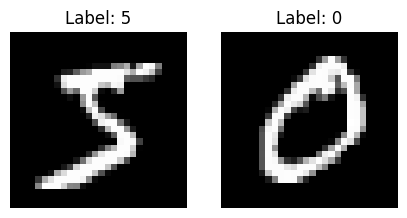

In [39]:
fig, ax = plt.subplots(1, 2, figsize = (5, 3))

#First Image
img1, label1 = train_set[0]
ax[0].imshow(img1[0], cmap = "gray")
ax[0].set_title(f"Label: {label1}")
ax[0].axis("off")

#Second Image
img2, label2 = train_set[1]
ax[1].imshow(img2[0], cmap = "gray")
ax[1].set_title(f"Label: {label2}")
ax[1].axis("off")

plt.show()

### 4. Setup DataLoaders

In [40]:
#Train the model in batches. Allows model to update weights more often
train_loader = DataLoader(train_set, batch_size = 32, shuffle = True, drop_last = True)
test_loader  = DataLoader(test_set, batch_size = 1000, shuffle = False, drop_last = True)

### 5. Model Architecture, Loss Function, and Optimizer

In [41]:
class MNISTClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        #Feature Extraction/Convolutional Layers
        self.convolution = nn.Sequential(
            #Starting Size [32 (batch size), 1 (channels), 28 (height), 28 (width)]
            nn.Conv2d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 1), #Upscale from 1 
            nn.ReLU(), #Non-linear activation function
            nn.MaxPool2d((2, 2)), #Spacial size reduction

            # [32, 32, 14, 14]
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d((2, 2))
            # [32, 64, 7, 7]
        )
        #Classification (Fully Connected Layers)
        self.classifier = nn.Sequential(
            # [32, 64, 7, 7]
            nn.Flatten(), #Flatten into 64*7*7 by 1 tensor
            # [32, 3136]
            nn.Linear(in_features = 3136, out_features = 128),
            # [32, 128]
            nn.ReLU(),
            nn.Dropout(0.4), #Turn off some neurons to prevent overfitting
            nn.Linear(in_features = 128, out_features = 10) #Downsize to number of classes
            # [32, 10]
        )
        #Model Pipeline 
        self.order = nn.Sequential(
            self.convolution,
            self.classifier
        )
    def forward(self, x):
        """Forward Pass Function Override"""
        return self.order(x)

In [42]:
#Initialize the model and move to device
model = MNISTClassifier().to(device)

In [43]:
#Accuracy, Loss, and Optimization Functions
def accuracy_function(pred: torch.Tensor, true: torch.Tensor) -> float:
    """Calculates classification accuracy as a percentage."""
    correct = torch.eq(pred, true).sum().item()
    return correct / len(pred) * 100

loss_function = torch.nn.CrossEntropyLoss() #Cross Entropy loss for multiclass classification. Takes logits as input
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.001)

### 6. Train-Test Loop

In [44]:
def train_test_loop(
    model: torch.nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    epochs: int,
    optimization_function: torch.optim.Optimizer,
    accuracy_function: callable,
    loss_function: torch.nn.Module,
    device: str
) -> None: 
    """Runs `epoch` number of training and testing loops for a model. Prints accuracy and loss every epoch."""
    torch.manual_seed(11)
    for epoch in range(epochs):
        print(f"Epoch: {epoch} =================================")
        #Training Loop
        model.train() #Set to train mode
        train_loss_total, train_acc_total = 0, 0 #Keep track of total loss and total acc, then divide by number of batches at end
        #Loop through training dataloader
        for X_batch, y_batch in train_dataloader:
            #Move batch to device
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #Forward Pass
            y_train_pred_logits = model(X_batch)
            #Loss Calculation
            loss = loss_function(y_train_pred_logits, y_batch)
            train_loss_total += loss.item()
            #Backpropagation to update weights
            optimization_function.zero_grad()
            loss.backward()
            #Gradient Descent
            optimization_function.step()
            #Calculate accuracy
            accuracy = accuracy_function(y_train_pred_logits.argmax(dim = 1), y_batch)
            train_acc_total += accuracy
        #Device total accuracy and loss by size of dataloader
        train_acc = train_acc_total / len(train_dataloader)
        train_loss = train_loss_total / len(train_dataloader)
        print(f"Train Loss: {train_loss} | Train Accuracy: {train_acc}")

        #Testing Loop
        model.eval() #Set to eval mode, untrack gradients
        test_loss_total, test_accuracy_total = 0, 0
        with torch.inference_mode():
            for X_batch, y_batch in test_dataloader:
                #Move to device
                X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                #Forward Pass
                y_test_pred_logits = model(X_batch)
                # Loss
                loss = loss_function(y_test_pred_logits, y_batch)
                test_loss_total += loss.item()
                # Accuracy
                accuracy = accuracy_function(y_test_pred_logits.argmax(dim = 1), y_batch)
                test_accuracy_total += accuracy
        #Divide totals by length of dataloader
        test_acc = test_accuracy_total / len(test_dataloader)
        test_loss = test_loss_total / len(test_dataloader)
        print(f"Test Loss: {test_loss} | Test Accuracy: {test_acc}")


In [45]:
#Run the training and testing loop for 5 epochs
train_test_loop(
    model = model,
    train_dataloader = train_loader,
    test_dataloader = test_loader,
    epochs = 7,
    optimization_function = optimizer,
    accuracy_function = accuracy_function,
    loss_function = loss_function,
    device = device
)

Epoch: 0 =================================
Train Loss: 0.20956429180999597 | Train Accuracy: 93.45333333333333
Test Loss: 0.062066939659416676 | Test Accuracy: 97.97
Epoch: 1 =================================
Train Loss: 0.07836587504784887 | Train Accuracy: 97.69833333333334
Test Loss: 0.03989974912256002 | Test Accuracy: 98.65
Epoch: 2 =================================
Train Loss: 0.057724378549757725 | Train Accuracy: 98.23833333333333
Test Loss: 0.026541224075481297 | Test Accuracy: 99.06
Epoch: 3 =================================
Train Loss: 0.04628414956366566 | Train Accuracy: 98.57333333333334
Test Loss: 0.03109415147919208 | Test Accuracy: 98.9
Epoch: 4 =================================
Train Loss: 0.03665421998932822 | Train Accuracy: 98.89833333333333
Test Loss: 0.026531986147165298 | Test Accuracy: 99.1
Epoch: 5 =================================
Train Loss: 0.031816906777649034 | Train Accuracy: 99.01333333333334
Test Loss: 0.02446080628433265 | Test Accuracy: 99.24
Epoch: 

### 7. View 2 Predictions on the Test Set

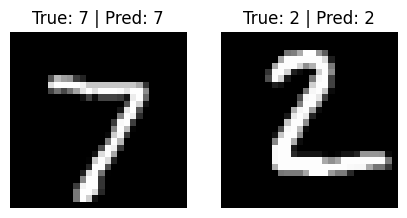

In [46]:
#Set model to evaluation mode and turn off gradient tracking
model.eval()
with torch.inference_mode():
    #Pick 2 samples from the test set
    img1, label1 = test_set[0]
    img2, label2 = test_set[1]

    #Forward pass
    out1 = model(img1.unsqueeze(0).to(device)) #Add expected batch dimension and move to device
    out2 = model(img2.unsqueeze(0).to(device))
    pred1 = out1.argmax(dim = 1).item()
    pred2 = out2.argmax(dim = 1).item()

#Plotting
fig, ax = plt.subplots(1, 2, figsize = (5, 3))

ax[0].imshow(img1[0], cmap = "gray")
ax[0].set_title(f"True: {label1} | Pred: {pred1}")
ax[0].axis("off")

ax[1].imshow(img2[0], cmap = "gray")
ax[1].set_title(f"True: {label2} | Pred: {pred2}")
ax[1].axis("off")

plt.show()